# Original post:
https://medium.com/swlh/automl-in-python-an-overview-of-the-mlbox-package-208118a7fe5

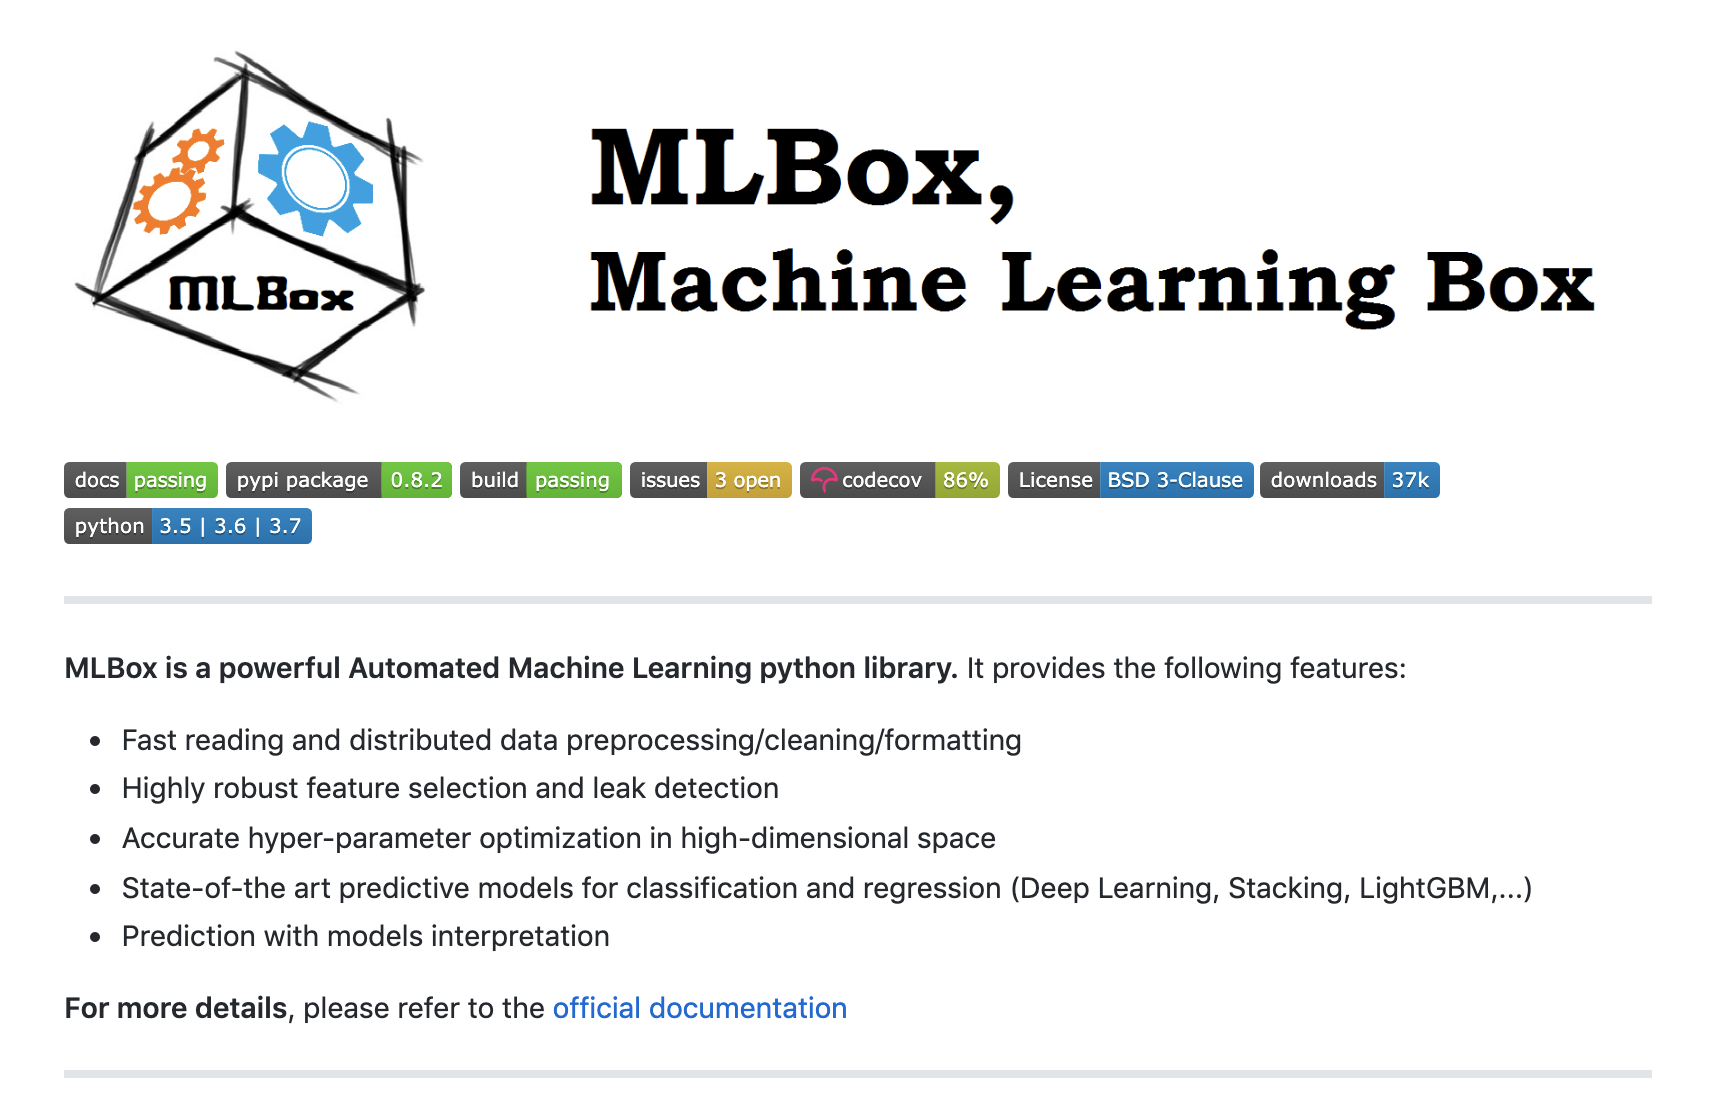

In [1]:
from IPython.display import Image
Image("img/mlbox.png")

# Testing MLBox: from data ingestion to model building

Now we’re going to test and run MLBox to quickly build a model to solve the Kaggle Titanic Challenge.

For more information about the documentation of the package and the API you can visit the following links:

* The official repository: https://github.com/AxeldeRomblay/MLBox
* The official documentation: https://mlbox.readthedocs.io/en/latest/

### Downloading the train and test datasets

For the purpose of this notebook, we’ll be solving the famous Titanic Kaggle challenge which consists in predicting the survival of passengers based on their attributes (Sex, Age, Name, etc).

If you’re not familiar with this competition you can check this article:
* https://ahmedbesbes.com/how-to-score-08134-in-titanic-kaggle-challenge.html

Let’s now download the data:
From Kaggle if you have an account

Download the train.csv and test.csv files and put them somewhere like ./data/

#### Importing MLBox

In [2]:
%%time

from IPython.core.display import display, HTML
display(HTML('<style>.prompt{width: 0px; min-width: 0px; visibility: collapse}</style>'))

import warnings
warnings.filterwarnings("ignore")

from mlbox.preprocessing.reader import Reader
from mlbox.preprocessing.drift_thresholder import Drift_thresholder
from mlbox.optimisation.optimiser import Optimiser 
from mlbox.prediction.predictor import Predictor

Using TensorFlow backend.


CPU times: user 2.9 s, sys: 648 ms, total: 3.55 s
Wall time: 2.98 s


#### Inputs to MLBox

If you’re having a train and a test set like in any Kaggle competition, you can feed these two paths directly to MLBox as well as the target name.

Otherwise, if fed a train set only, MLBox creates a test set.

In [3]:
paths = ["./data/train.csv", "./data/test.csv"] 
target_name = "Survived"

#### Reading and preprocessing

The Reader class of MLBox is in charge of preparing the data.

It basically provides methods and utilities to:

1. Read in the data with the correct separator (csv, xls, json, and h5) and load it
2. Clean the data by:


* deleting Unnamed column
* inferring column types (float, int, list)
* processing dates and extracting relevant information from it: year, month, day, dayofweek, hour, etc.
* removing duplicates
* preparing train and test splits

More information here: https://mlbox.readthedocs.io/en/latest/features.html#mlbox.preprocessing.Reader

In [4]:
rd = Reader(sep=",")
df = rd.train_test_split(paths, target_name)


reading csv : train.csv ...
cleaning data ...
CPU time: 6.899881839752197 seconds

reading csv : test.csv ...
cleaning data ...
CPU time: 0.07294154167175293 seconds

> Number of common features : 11

gathering and crunching for train and test datasets ...
reindexing for train and test datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> Number of categorical features: 5
> Number of numerical features: 6
> Number of training samples : 891
> Number of test samples : 418

> Top sparse features (% missing values on train set):
Cabin       77.1
Age         19.9
Embarked     0.2
dtype: float64

> Task : classification
0.0    549
1.0    342
Name: Survived, dtype: int64

encoding target ...


When this function is done running, it creates a folder named save where it dumps the target encoder for later use.

In [5]:
df["train"].head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0.0,1.0,3.0,male,1.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0.0,2.0,1.0,female,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0.0,3.0,3.0,female,0.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0.0,4.0,1.0,female,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0.0,5.0,3.0,male,0.0,373450


#### Removing drift

This is an innovative feature I haven’t encountered in other packages. The main idea is to automatically detect and remove variables that have a distribution that is substantially different between the train and the test set.

This happens quite a lot and we generally talk about biased data. You could have for example a situation when the train set has a population of young people whereas the test has elderly only. This indicates that the age feature is not robust and may lead to a poor performance of the model when testing. So it has to be discarded.

More information:

* about the algorithm: https://github.com/AxeldeRomblay/MLBox/blob/master/docs/webinars/features.pdf
* about MLBox implementation: https://mlbox.readthedocs.io/en/latest/features.html#mlbox.preprocessing.Drift_thresholder

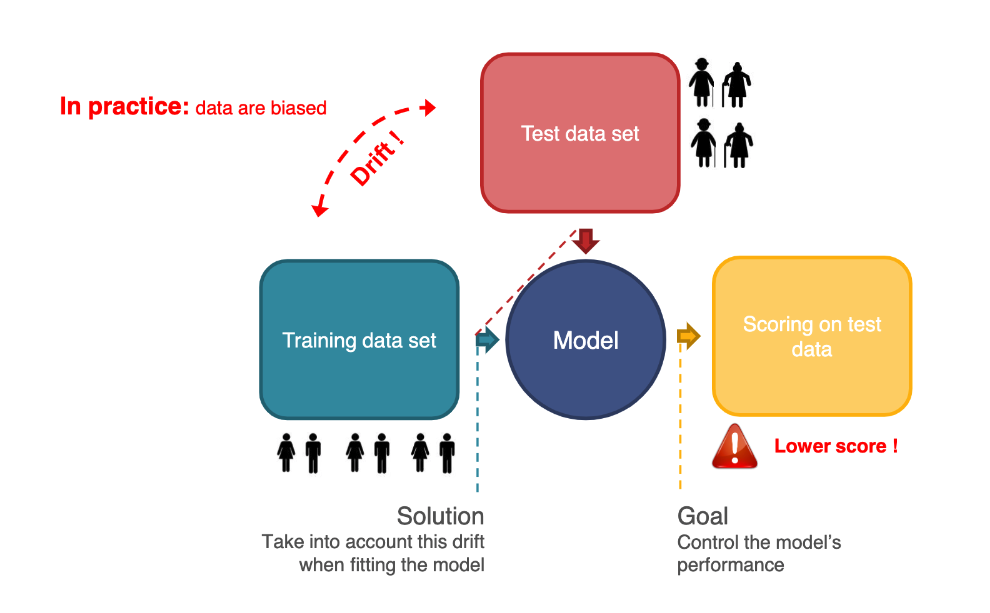

In [6]:
from IPython.display import Image
Image("img/drift1.png")

#### How does MLBox compute drifts for individual variables

MLBox builds a classifier that separates train from test data. It then uses the ROC score related to this classifier as a measure of the drift.

This makes sense:

* If the drift score is high (i.e. the ROC score is high) the ability the discern train data from test data is easy, which means that the two distributions are very different.
* Otherwise, if the drift score is low (i.e. the ROC score is low) the classifier is not able to separate the two disctributions correctly.

MLBox provides a class called Drift_thresholder that takes as input the train and test sets as well as the target and computes a drift score of each one of the variables.

Drift_thresholder then deletes the variables that have a drift score higher that a threshold (default to 0.6).    

In [7]:
dft = Drift_thresholder()
df = dft.fit_transform(df)


computing drifts ...
CPU time: 0.26589107513427734 seconds

> Top 10 drifts

('PassengerId', 1.0)
('Name', 0.992967782483366)
('Ticket', 0.6528892800256894)
('Cabin', 0.16947315624816928)
('Embarked', 0.07661467884821294)
('Fare', 0.056393334848914956)
('SibSp', 0.03612196701898718)
('Age', 0.022104337415679964)
('Pclass', 0.02071172218668993)
('Sex', 0.019038575726316065)

> Deleted variables : ['Name', 'PassengerId', 'Ticket']
> Drift coefficients dumped into directory : save


As you see here, Name, PassengerId and Ticket get removed beacause of their respective drift scores. If you think about it, this is not surprising at all because these variables, given their nature, can have any random value thus resulting in plausible drift between their train and test distributions.
The heavy lifting : optimizing

This section performs the optimisation of the pipeline and tries different configurations of the parameters:

* NA encoder (missing values encoder)
* CA encoder (categorical features encoder)
* Feature selector (OPTIONAL)
* Stacking estimator — feature engineer (OPTIONAL)
* Estimator (classifier or regressor)

More details here: https://mlbox.readthedocs.io/en/latest/features.html#mlbox.optimisation.Optimiser

We first instantiate the Optimiser class:

In [8]:
opt = Optimiser()

Then we can run it using the default model configuration set as default (LightGBM) without any autoML or complex grid search.

This should be the first baseline

In [9]:
warnings.filterwarnings('ignore', category=DeprecationWarning)
score = opt.evaluate(None, df)

No parameters set. Default configuration is tested

##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'label_encoding'}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}


MEAN SCORE : neg_log_loss = -0.6324717748298669
VARIANCE : 0.003224557409561235 (fold 1 = -0.6356963322394281, fold 2 = -0.6292472174203056)
CPU time: 0.5324125289916992 seconds



The neg log loss = -0.6325 as a first baseline.

Let’s now define a space of multiple configurations:

* ne_numericalstrategy: how to handle missing data in numerical features
* ce__strategy: how to handle categorical variables encoding
* fs: feature selection
* stck: meta-features stacker
* est: final estimator

In [10]:
space = {
        'ne__numerical_strategy':{"search":"choice",
                                 "space":[0, "mean"]},
        'ce__strategy':{"search":"choice",
                        "space":["label_encoding", "random_projection", "entity_embedding"]}, 
        'fs__threshold':{"search":"uniform",
                        "space":[0.001, 0.2]}, 
        'est__strategy':{"search":"choice", 
                         "space":["RandomForest", "ExtraTrees", "LightGBM"]},
        'est__max_depth':{"search":"choice", 
                          "space":[8, 9, 10, 11, 12, 13]}
        }

params = opt.optimise(space, df, 15)

##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'entity_embedding'}    
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.01987068816306081}
>>> ESTIMATOR :{'strategy': 'ExtraTrees', 'max_depth': 11, 'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 400, 'n_jobs': -1, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}
MEAN SCORE : neg_log_loss = -0.4935965214698759     
VARIANCE : 0.041139181329479746 (fold 1 = -0.5347357027993557, fold 2 = -0.4524573401403962)
CPU time: 2.135918140411377 seconds                 
#############################################

MEAN SCORE : neg_log_loss = -0.5107059716172607                               
VARIANCE : 0.04432097743056704 (fold 1 = -0.4663849941866937, fold 2 = -0.5550269490478278)
CPU time: 2.1444809436798096 seconds                                          
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}                                
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.14618390504797366}    
>>> ESTIMATOR :{'strategy': 'RandomForest', 'max_depth': 10, 'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 400, 'n_jobs': -1, 'oob_score': False, 'random_sta

Let’s now evaluate this model:

In [11]:
opt.evaluate(params, df)


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'label_encoding'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.19439766560774696}

>>> ESTIMATOR :{'strategy': 'ExtraTrees', 'max_depth': 10, 'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 400, 'n_jobs': -1, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


MEAN SCORE : neg_log_loss = -0.44571612435265695
VARIANCE : 0.01881027797695281 (fold 1 = -0.46452640232960973, fold 2 = -0.4269058463757041)
CPU time: 1.8123133182525635 seconds



-0.44571612435265695

Running this pipeline resulted in a higher neg loss, which is better.

There’s clearly very good potential of more improvement if we define a better space of search or stacking operations and maybe other feature selection techniques.

Now we fit the optimal pipeline and predict on our test dataset.

More details here: https://mlbox.readthedocs.io/en/latest/features.html#mlbox.prediction.Predictor

In [12]:
prd = Predictor()
prd.fit_predict(params, df)


fitting the pipeline ...
CPU time: 1.1423206329345703 seconds

> Feature importances dumped into directory : save

predicting ...
CPU time: 0.2297976016998291 seconds

> Overview on predictions : 

        0.0       1.0  Survived_predicted
0  0.887264  0.112736                   0
1  0.702887  0.297113                   0
2  0.852334  0.147666                   0
3  0.871219  0.128781                   0
4  0.539246  0.460754                   0
5  0.876029  0.123971                   0
6  0.524391  0.475609                   0
7  0.781385  0.218615                   0
8  0.264126  0.735874                   1
9  0.912716  0.087284                   0

dumping predictions into directory : save ...


#### 6 — Conclusion

Running an automated AutoML pipeline has never been easier. With MLBox, you can do this very quickly and efficiently so that you can focus on what really matters when solving a business problem.

* Understanding the problem
* Acquiring and consolidating the right data
* Formalizing the performance metrics to reach and compute

Let’s hope these three first steps don’t get automated soon :)

Hope you liked this library. Don’t hesitate to star it on github or report an issue to its contributor.